## CNN Model with Image Augmentation: Detecting Diabetic Retinopathy


### Imports 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
# setting a random seed for reproducibility
np.random.seed(42)

### Reading in image data as X and y

In [ ]:
# specify the path with the subfolders of cleaned eye images 
clean_path = '/content/drive/MyDrive/cleaned_eye_images/'

# make a dictionary of eye conditions and integers because the target y needs to be a number, not a string
# setting the condition to be 1 so that 'positive' results mean the eye has the condition
condition_dict = {'retinopathy':1, 'normal': 0}

# make empty lists for X and y
X=[]
y=[]

# iterate through each subfolder (= condition)
for condition in os.listdir(clean_path):
    
    # make sure the subfolder is actually the name of a condition (e.g., not 'DS_Store')
    if condition in condition_dict.keys():
        
        # allows you to specify how many images to collect from each folder
        # this allows the final number to be divisible by the desired batch size
        number=0
        total_num = 468
        
        # iterate through each image file in the subfolder
        for file in os.listdir(clean_path+condition):
            
            if number < total_num:
            
            # added a try/except so that DS_Store files don't trip an error
                try:
                    # load the image file
                    image = load_img(clean_path+condition+'/'+file)
                    
                    # turn the image into an array
                    image_arr = img_to_array(image)
                
                    # add the image array to X
                    X.append(image_arr)
                
                    # use the condition_dict to add the right number to y that corresponds to the eye condition
                    y.append(condition_dict[condition])
                    
                    number+=1
                
                except:
                    continue

In [ ]:
# change X and y into numpy arrays
X = np.array(X)
y = np.array(y)

In [ ]:
# checking the shape of X
# there are 768 512x512 images with 3 channels (RGB)
X.shape

(768, 512, 512, 3)

In [ ]:
# y matches the number of images in X
y.shape

(768,)

### Baseline Model
Our dataset is unevenly distributed between normal eyes and eyes with diabetic retinopathy, and the model needs to make correct predictions more than 60.9% of the time to beat the baseline.

In [ ]:
print(f'There are {len(y)-y.sum()} non-diseased eye images and {y.sum()} images of eyes with diabetic retinopathy in the dataset.')

# Since y is binary with values of 0 and 1, the baseline accuracy can be found by summing y and dividing by the length of y
# The baseline accuracy is the higher of this value and 1 - this value
# rounding the numbers to 3 places to make the formatting nicer
print(f'This gives a baseline accuracy of {round(np.array([(y.sum() / len(y)),(1-(y.sum()/len(y)))]).max(), 3)}')

There are 300 non-diseased eye images and 468 images of eyes with diabetic retinopathy in the dataset.
This gives a baseline accuracy of 0.609


### Train-Test Split

In [ ]:
# regular train-test-split 
# no need for StandardScaler because the images have already been normalized

# using a test_size of 128 so test and train sizes are both divisible by 32, the batch_size
# to use with image augmentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=128, random_state=42, stratify=y)

In [ ]:
X_train.shape

(640, 512, 512, 3)

### Image Augmentation 

In [ ]:
# creating the same ImageDataGenerators as the ones made in the Glaucoma model

image_generator_train = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, rotation_range=30, brightness_range=(.8,1.2))
image_generator_test = ImageDataGenerator(rescale=1.0/255.0)
image_generator_train.fit(X_train)

### Building the CNN Model

In [ ]:
# instantiate a Sequential model (that will process each layer sequentially)
model = Sequential()

In [ ]:
# add a Convolutional 2D layer that will create 16 3x3 filters to detect image features
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(512,512,3)))

In [ ]:
# add a MaxPooling 2D layer that will take the maximum value in every 2x2 grid (with a stride defaulting to the pool_size)
# this effectively cuts the dimensions of the data in half, and helps get rid of noise caused by small variations in the image

model.add(MaxPooling2D(pool_size=(2,2)))

In [ ]:
# add more convolutional layers (with max pooling between each one) 

# increasing filters to 32
# input shape is only needed for the first layer above
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

# increasing filters to 64
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

In [ ]:
# add a flatten layer to bridge between the convolutional layers and the dense layers
model.add(Flatten())

In [ ]:
# the dense layers analyze the features that were identified in the convolutional layers 
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))

In [ ]:
# add the output layer with sigmoid activatin since it's a binary classification
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the model using binary_crossentropy, accuracy metrics, and the adam optimizer
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

### Fitting the Model

In [ ]:
# adding early stopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=.01, patience=5, verbose=1, mode='auto')

In [ ]:
# fit the model and save it as h so the accuracy and loss scores for each epoch can be visualized

# use a batch size divisible by the number of images in X_train
h = model.fit(image_generator_train.flow(X_train, y_train, batch_size=32, seed=42), validation_data=(image_generator_test.flow(X_test, y_test, batch_size=32, seed=42)), steps_per_epoch=len(X_train)/32, epochs=30, callbacks=[early_stop])

Epoch 1/30
20/20 [==============================] - 71s 3s/step - loss: 0.7241 - accuracy: 0.6062 - val_loss: 0.6203 - val_accuracy: 0.6406
Epoch 2/30
20/20 [==============================] - 51s 3s/step - loss: 0.4799 - accuracy: 0.7688 - val_loss: 0.2817 - val_accuracy: 0.8750
Epoch 3/30
20/20 [==============================] - 53s 3s/step - loss: 0.3642 - accuracy: 0.8422 - val_loss: 0.2683 - val_accuracy: 0.9141
Epoch 4/30
20/20 [==============================] - 49s 2s/step - loss: 0.3367 - accuracy: 0.8484 - val_loss: 0.2582 - val_accuracy: 0.9141
Epoch 5/30
20/20 [==============================] - 51s 3s/step - loss: 0.3486 - accuracy: 0.8516 - val_loss: 0.2268 - val_accuracy: 0.9141
Epoch 6/30
20/20 [==============================] - 52s 3s/step - loss: 0.3174 - accuracy: 0.8672 - val_loss: 0.2188 - val_accuracy: 0.9219
Epoch 7/30
20/20 [==============================] - 51s 3s/step - loss: 0.3023 - accuracy: 0.8687 - val_loss: 0.2385 - val_accuracy: 0.9219
Epoch 8/30
20/20 [==

This model reaches 85.8% training accuracy and 90.6% testing accuracy before early stopping after 9 epochs. 

As with the Glaucoma detection model, it's possible that early stopping ended training too early. The training accuracy is lower than the testing accuracy, indicating the model still has room to become more accurate. However, training and testing accuracy flatten out over the final epochs, and it's unclear if more training would increase the scores.

### Saving the Model

In [ ]:
# code to save the model as an h5 file so that it can be used in Flask

# commenting out the code so it doesn't run again by accident
model.save("/content/drive/MyDrive/FINAL MODELS/DIABETIC RETINOPATHY/retinopathy_model.h5")

### Visualizing the accuracy and loss scores for each epoch

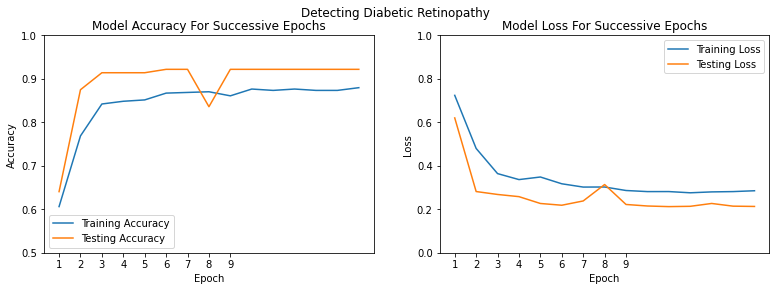

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13,4))

fig.suptitle('Detecting Diabetic Retinopathy')

# plot training and testing accuracy
axs[0].plot(h.history['accuracy'], label='Training Accuracy')
axs[0].plot(h.history['val_accuracy'], label='Testing Accuracy')

# add titles, labels, and tick formatting 
axs[0].set_title('Model Accuracy For Successive Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_xticks(ticks=range(0,9))
axs[0].set_xticklabels(labels=range(1,10))
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(.5,1)

# add a legend
axs[0].legend()

# plot training and testing loss
axs[1].plot(h.history['loss'], label='Training Loss')
axs[1].plot(h.history['val_loss'], label='Testing Loss')

# add titles, labels, and tick formatting
axs[1].set_title('Model Loss For Successive Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_xticks(ticks=range(0,9))
axs[1].set_xticklabels(labels=range(1,10))
axs[1].set_ylabel('Loss')
axs[1].set_ylim(0,1)

# add a legend
axs[1].legend();


These plots have a very similar shape to the plots for the Glaucoma model, but the training and testing scores are further apart. The model consistently does better with the testing data instead of the training data, perhaps indicating the image augmentation is producing images that are outside the range of what would be seen in actual images, and that diabetic retinopathy is easier for machine learning to detect than glaucoma. The training accuracy scores are roughly the same as in the Glaucoma model, around 85%, while the testing accuracy mainly stays in the 90-94% range, which is better than in the Glaucoma model. Using early stopping may again have limited the model's ability to learn, since it's unclear if the scores have truly leveled out or if they would continue to improve.

### Making a Confusion Matrix

In [ ]:
# generate predictions from X_test
# in order to generate predictions correctly, the X_test images need to be fed to model.predict through
# image_generator_test with shuffle set to False

preds = model.predict(image_generator_test.flow(X_test, shuffle=False))

4/4 [==============================] - 1s 213ms/step


In [ ]:
# the predictions are probabilities of whether to class the image as 0 (normal) or 1 (diseased)
print(preds[0:10])

[[0.21806848]
 [0.24290659]
 [0.9999639 ]
 [0.9997608 ]
 [0.14168884]
 [0.21551044]
 [0.154401  ]
 [0.99991596]
 [0.99986315]
 [0.9998411 ]]


In [ ]:
# change the probabilities into 1s and 0s by testing if the probability is greater than .5 and turning 
# the True/False value into an int of 1 or 0
preds = [int(x>0.5) for x in preds]

In [ ]:
# now the predictions can be used in the confusion matrix
print(preds)

[0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]


In [ ]:
# the true values to compare to the predictions are stored in y_test
y_test

array([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

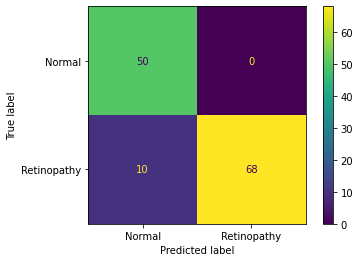

In [ ]:
# make and display a confusion matrix
conf_matrix = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal','Retinopathy']).plot();

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        50
           1       1.00      0.87      0.93        78

    accuracy                           0.92       128
   macro avg       0.92      0.94      0.92       128
weighted avg       0.93      0.92      0.92       128

